## INFO284 - Group exam

Your tasks are:

#### Preprocessing: 
Get to understand the data and remove columns and rows that you do not find useful for your machine learning models. It is possible to for example focus on one type of gear, one or a few species, group categories of species, etc. etc. This will help to reduce
the data set you are working on. Understanding data and preparing them for model building
is a main task of machine learning.

#### Supervised learning: 
Build at least three machine learning models to predict or classify catch
data related to a fishery operation, i.e. species caught, amounts of one fish species (sums of amounts is also possible), or other features related to fish catches. One of the models needs to be a deep learning model.

#### Unsupervised learning: 
Build a clustering model for the data set. You may use a different preprocessing for this task than for the data in task b).


You shall deliver code in the form of a well commented Jupyter notebook. This code needs to run on the original data set, so any preprocessing you choose to do needs to be programmed in Python and included in the notebook. The code shall in the end return the results of your experiments with your chosen models. You need to explain

- Important and relevant properties of the data
- how you preprocessed data like which features you selected, did you do dimension reduction 
- how you reformatted data, etc.
- how you decided on parameters for your machine learning models,
- if you used any regularization techniques? In case how.
- how the methods were measured and compared

Please inform about any special Python libraries that need to be installed to make your code runnable.

Finally, as a concluding comment in the Jupyter notebook, you need to write a summary of your results, and discuss consequences of such results.

It is not necessarily so that high scores for machine learning models will give a good grade on your report, or vice versa, low scores a bad grade. What counts is a well-argued, well described, and smart machine learning investigation from start to end. The problem may in fact be of such nature that it is not possible to get really good results on these data.
Final note: These data are prepared for this course and are shared with you in confidence that you do not share them in any way but use them only for the purpose of this exam.


# 1.0: Preprosessering


## 1.1: Importerer nødvendige biblioteker
Vi starter med å åpne csv-filen som inneholder datasettet vi skal arbeide videre med, og å importere nødvendige moduler til senere bruk. Filen inneholder en rekke data om fisketurer og fangst, og er inndelt i kolonner og rader.

Filen skiller de ulike elementene i en rad med ";", mens standard separator er ",". På samme måte brukes det i filen "," for å angi desimaler, mens standard er "." Vi må derfor angi hvordan maskinen skal lese filen ved å angi ny separator og desimaltegn, slik at maskinen leser dataene på korrekt måte.

In [127]:
import pandas as pd
import numpy as np
from sklearn import linear_model  # For den lineære modellen.
from sklearn.model_selection import train_test_split  # For å splitte datasettet.
import datetime as dt
import matplotlib.pyplot as plt  # For statistikk og grafiske fremstillinger.
import seaborn as sns  # For statistikk og grafiske fremstillinger
from sklearn.tree import DecisionTreeRegressor
import time

from sklearn.preprocessing import StandardScaler # For KNN-regressor
from sklearn.neighbors import KNeighborsRegressor # For kNN-regressor
from sklearn.metrics import mean_squared_error # For å måle resultat

df = pd.read_csv("GroupExam2024_data_and_documentation/elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv", sep=';', decimal=',')

## 1.2: Splitte datasett
Vi splitter datasettet vårt inn i train og test data tidlig. Dette er fordi at modellene kan «huske» settet som den bygges opp av (train settet), og vil dermed alltid yte godt på dette settet. Vi får imidlertid ikke muligheten til å se hvor godt modellene fungerer på ny data. For å kunne vurdere modellenes ytelse, må vi altså vise modellene ny data når de skal testes, altså data som modellen ikke tidligere har sett (Müller & Guido, 2017).

Ved å splitte datasettet vårt tidlig sørger vi altså for at modellene ikke allerede har "sett" test dataene slik at vi risikerer uriktige resultater når vi skal vurdere hvor gode modellene vi har bygd opp er.


In [128]:
# Splitter datasettet i train_df og test_df
train_df, test_df = train_test_split(df, test_size = 0.15)

## 1.3: Utforske datasettet:
Før man skal bygge maskinlæringsmodeller, bør man aller først utforske datasettet man skal jobbe med (Müller & Guido, 2017). Vi starter derfor med å undersøke hva datasettet inneholder av informasjon, og hvordan dataen er organisert. 

In [129]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 259618 entries, 278957 to 12242
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Melding ID                259618 non-null  int64  
 1   Meldingstidspunkt         259618 non-null  object 
 2   Meldingsdato              259618 non-null  object 
 3   Meldingsklokkeslett       259618 non-null  object 
 4   Starttidspunkt            259618 non-null  object 
 5   Startdato                 259618 non-null  object 
 6   Startklokkeslett          259618 non-null  object 
 7   Startposisjon bredde      259618 non-null  float64
 8   Startposisjon lengde      259618 non-null  float64
 9   Hovedområde start (kode)  257915 non-null  float64
 10  Hovedområde start         256117 non-null  object 
 11  Lokasjon start (kode)     257915 non-null  float64
 12  Havdybde start            259618 non-null  int64  
 13  Stopptidspunkt            259618 non-null  ob

Av df.info ser vi tittel på de ulike kolonnene og hvilken datatype de inneholder. I tillegg ser vi hvor mange "non-null" verdier som eksisterer. Her ser vi at det eksisterer null-verdier i de fleste kolonner. Dette indikerer at de kan  finnes overflødige felter som kan renses bort på et senere tidspunkt.

**Organisering av datasettet**

Datasettet er videre organisert slik at hver rad inneholder informasjon om fangst av en art, herunder blant annet informasjon om tidspunkt, lokasjon, båtstørrelse, mengde fisk og fiskeart. 

***Fiskeaktivitet:***

Vi ser at flere rader kan inneholde informasjon om samme fisketur, hvor blant annet start og sluttidspunkt er den samme. De ulike fangstene som er gjort på samme tidspunkt med samme melding ID ser altså ut til å være knyttet til samme fiskeaktivitet. 

***Bruttotonnasje:***

Vi ser videre at det finnes to ulike kolonner for Bruttotonnasje. "Bruttotonn er totalvolumet av alle lukkede rom som er i bruk på et skip." (Osnes, 2024). Bruttotonnasje sier altså noe om det totale volumet av hulrom i båten. Selv om det ikke kan sammenlignes med lastekapasitet, kan det være en indikator på dette. Vi ser her at Bruttotonnasje er delt inn i to ulike kolonner («Bruttotonnasje 1969» og «Bruttotonnasje annen»). Verdien per båt er videre fordelt på en av de to kolonnene, men aldri begge samtidig. Dette betyr også at det alltid vil stå et felt tomt per rad.


**Videre undersøkelser**

Vi ønsker som utgangspunkt å se om det mulig å predikere rundvekt av en bestemt art med den informasjonen vi har. Siden fiskere bruker ulike redskaper for å fange fisk, kan vi anta at noen redskaper og metoder er mer egnet for å fange bestemte arter. Vi vet også at det foregår fiske etter ulike arter på ulike steder og tidspunkt. Kunnskap om hvordan, hvor og hva som fiskes etter er derfor viktig for å forstå datasettet. Videre vil derfor nå undersøke denne type informasjonen.

Vi undersøker derfor hvor mange registreringer det er av de ulike fisketypene, og hvor mye det fiskes av hver.

In [ ]:
# Først undersøker vi hvor mange registreringer det er av de ulike fisketypene og hvor mye det fiskes av hver.

species_weight_sum = train_df.groupby('Art - gruppe')['Rundvekt'].sum().sort_values(ascending=False)
print(train_df['Art - gruppe'].value_counts())
print(species_weight_sum)

Art - gruppe
Torsk                                       47994
Annen torskefisk                            38549
Sei                                         36150
Hyse                                        33281
Annen flatfisk, bunnfisk og dypvannsfisk    21529
Uer                                         16754
Steinbiter                                  13817
Dypvannsreke                                11599
Blåkveite                                    6806
Snøkrabbe                                    5124
Sild, annen                                  5114
Skater og annen bruskfisk                    3437
Makrell                                      2552
Kolmule                                      2433
Øyepål                                       1886
Annen pelagisk fisk                          1523
Vassild og strømsild                         1418
Andre skalldyr, bløtdyr og pigghuder         1142
Lodde                                        1022
Tobis og annen sil                   

Her ser vi at det er en hovedvekt av fiske etter torsk og sei. 

Vi ser videre på hvilke redskaper som brukes hyppigst, og hvor hvor mye total rundvekt de ulike redskapene er registrert med.

In [ ]:
# Gjør samme undersøkelse av reskaper.

redskap_weight_sum = train_df.groupby('Redskap FDIR')['Rundvekt'].sum().sort_values(ascending=False)
print(train_df['Redskap FDIR'].value_counts())
print(redskap_weight_sum)

Redskap FDIR
Bunntrål                                  102353
Snurrevad                                  43849
Andre liner                                37426
Reketrål                                   19103
Udefinert garn                             16406
Udefinert trål                             13502
Snurpenot/ringnot                          10807
Teiner                                      5756
Bunntrål par                                2836
Dobbeltrål                                  2439
Flytetrål                                   2285
Flytetrål par                               1305
Settegarn                                    557
Harpun og lignende uspesifiserte typer       413
Annet                                        392
Dorg/harp/snik                                13
Juksa/pilk                                    13
Name: count, dtype: int64
Redskap FDIR
Snurpenot/ringnot                         668542733.0
Flytetrål                                 396140772.0
Bunntrå

Brunntrål og Snurrevad viser seg å være de mest brukte fangstredskapene, etterfulgt av andre liner og reketrål.

Vi vet at Fra fiskeridirektoratet bunntrål og snurrevad er fiskeredskaper som samler fisk ved å slepe eller trekke garn/not gjennom vannet. "Andre liner" er fiskeredskaper med agn og krok som kan settes ut (Fiskeridirektoratet, 2022).

Vi har nå fått en oversikt over hvilke fisker som fiskes, og hvilke redskaper som brukes. Vi ser det videre som naturlig å undersøke hvordan sammensetningen av fisk er med de ulike fangstmetodene, og hvor vanlig det er at de blir brukt. 

Vi har valgt å fokusere spesielt på bunntrål og snurrevad, ettersom vi har mye data på disse fiskeredskapene, og de har noe lik fangstmetodikk. 

In [ ]:
# Ser etter hvilke fisk som blir fisket med Bunntrål:
condition = train_df[train_df['Redskap FDIR'] == 'Bunntrål']
species_weight_sum = condition.groupby('Art - gruppe')['Rundvekt'].sum().sort_values(ascending=False)
print(condition['Art - gruppe'].value_counts(), species_weight_sum)

Art - gruppe
Torsk                                       19848
Sei                                         15510
Hyse                                        14086
Annen torskefisk                            12712
Uer                                         12128
Annen flatfisk, bunnfisk og dypvannsfisk     7360
Dypvannsreke                                 6302
Steinbiter                                   6191
Blåkveite                                    4326
Skater og annen bruskfisk                     680
Øyepål                                        619
Andre skalldyr, bløtdyr og pigghuder          518
Kolmule                                       411
Vassild og strømsild                          404
Annen pelagisk fisk                           344
Sild, annen                                   275
Makrell                                       187
Tobis og annen sil                            155
Lodde                                          53
Haifisk                              

In [ ]:
# Ser etter hvilke fisk som blir fisket med Snurrevad:
condition = train_df[train_df['Redskap FDIR'] == 'Snurrevad']

species_weight_sum = condition.groupby('Art - gruppe')['Rundvekt'].sum().sort_values(ascending=False)
print(condition['Art - gruppe'].value_counts(), species_weight_sum)

Art - gruppe
Torsk                                       13843
Hyse                                        10219
Sei                                          9557
Annen flatfisk, bunnfisk og dypvannsfisk     3566
Annen torskefisk                             3488
Steinbiter                                   1097
Uer                                           690
Blåkveite                                     316
Sild, annen                                    25
Makrell                                        22
Skater og annen bruskfisk                      10
Lodde                                           9
Dypvannsreke                                    9
Andre skalldyr, bløtdyr og pigghuder            3
Haifisk                                         3
Annen pelagisk fisk                             1
Sjøpattedyr                                     1
Name: count, dtype: int64 Art - gruppe
Torsk                                       48689671.0
Sei                                        

Etter å ha studert de ulike redskapene og hva som blir fisket med de aktuelle, ser vi også konturene av hvordan de blir brukt. Vi ser blant annet at Bunntrål fanger mest torsk og sei, men også mye av andre arter. Dette er det redskapet som vi har undersøkt som har jevnest fordeling av arter, som altså betyr at det er det redskapet som bidrar med mest bifangst. Snurrevad gir også mye torsk og sei, men virker å være et noe mer målrettet fiskeredskap, ettersom spredningen av fangst av forskjellige arter ikke er like stor. 

Basert på denne infoen ser vi det som interessant å dykke videre inn i et bestemt redskap og art. Vi vil også se på muligheten for å begrense oss til et bestemt område. Vi danner oss derfor en oversikt over de ulike fiskeområdene og se på fordelingen registreringer som er gjort per område.


In [ ]:
print(train_df['Hovedområde start'].value_counts())

Hovedområde start
Eigersundbanken                  38670
Røstbanken til Malangsgrunnen    24764
Vest-Finnmark                    23519
Øst-Finnmark                     22964
Bjørnøya                         21474
Shetland                         21064
Nordkappbanken                   15828
Vikingbanken                     14057
Skagerrak                        13663
Storegga-Frøyabanken             12614
Helgelandsbanken                  7336
Sentralbanken                     4735
Storbanken                        4072
Thor Iversens Bank                3862
Vestfjorden (Lofoten)             3821
Sentrale Nordsjø                  2897
Hopen                             2709
Vest av Skottland (Hebridene)     1740
Sørlige Norskehav                 1706
Østlige Norskehav                 1638
Admiralityfeltet                  1624
Skolpenbanken                     1591
Gåsebanken                        1442
Storfjord/Hinlopenstredet         1152
Vest-Spitsbergen                  1033
Vest av

### 1.3.1 Konklusjon av første titt på data:
Vi ønsker å prøve ut forskjellige maskinlæringsmodeller for å predikere fangst av en bestemt type fisk. Ut fra det vi har sett av data har ønsker vi å filtrere ut data etter følgende betingelser: Hovedart - Sei, Område - Norskekysten, fangstredskap - Trål.

Vi har valgt å fokusere på seifiske, siden dette er en av de fiskene som blir fisket hyppigst i Norge i dag.

Når det gjelder lokasjon, er det hovedsaklig fiske etter to grupper av sei. En gruppe som beiter i havområdene mellom Norge og Skottland (Havforskningsinstituttet, 2019), og en annen som beiter i kystområdene fra vestlandet til finnmark (Havforskningsinstituttet 2019).

Dersom vi ønsker å fokusere på den nordøstarktiske seien, kan det se ut fra denne informasjon at det kan være lurt å fokusere på hovedområdene med kode fra 0-7 og 28 men uten hovedområde 2. Om vi skal inkludere Nordsjøseien, så kan vi inkludere områdene 40-43, men da beveger vi oss også litt utenfor de de norske områdene. 

Siden det eksisterer et så stort omfang av trålfiske, så eksisterer det også mye data. Trål er også det redskapet som er mest brukt for å fiske sei.

For å finne oversikt over de aktuelle hovedområdene, benytter vi oss av karttjenesten til fiskeridirektoratet (Fiskeridirektoratet, 2018).

## 1.4: Filtrere data
Vi har nå dannet oss en grov oversikt over datasettet, og spesifisert nærmere hva vi ønsker å se på. Vi kan da starte prosessen med å filtrere data. Vi spesifiserer altså for train-settet vårt at vi vil se på nettopp Sei, nordøstlige områder og bunntrål, og filtrerer bort alle rader som ikke inneholder disse verdiene. Vi gjør det samme for test-settet.

Vi har her valgt å ta utgangspunkt i alle radene hvor sei er angitt som Hovedart. Dette innebærer at vi også inkluderer informasjon om bifangst på turer hvor sei er registrert som hovedart. 

--HER MÅ VI FORKLARE HVA SOM SKJER UNDER. Usikker på om jeg har forstått riktig --

In [ ]:
# Lager en betingelse med aktuelle områder.
northeastern = [0, 1, 3, 4, 5, 6, 7, 28]
northeastern_ocean = [30, 34, 37, 39, 12, 36] # For å undersøke om det er noe særlig seifiske utenfor de mer kystnære strøk
northsea = [40, 41, 42, 43] # For å undersøke seifiske
# Legger inn betingelser i train_df.
filtered_train_df = train_df[
    (train_df['Hovedart FAO'] == 'Sei') &
    (train_df['Hovedområde start (kode)'].isin(northeastern)) &
    (train_df['Redskap FDIR'] == 'Bunntrål')
]

# Gjør det samme med test-settet
filtered_test_df = test_df[
    (test_df['Hovedart FAO'] == 'Sei') &
    (test_df['Hovedområde start (kode)'].isin(northeastern)) &
    (test_df['Redskap FDIR'] == 'Bunntrål')
]

filtered_train_df.describe()  # Får her et inntrykk av ekstremverdier og gjennomsnitt.

,Melding ID,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),Lokasjon start (kode),Havdybde start,Varighet,Fangstår,Stopposisjon bredde,Stopposisjon lengde,...,Redskap FDIR (kode),Hovedart - FDIR (kode),Art - FDIR (kode),Art - gruppe (kode),Rundvekt,Lengdegruppe (kode),Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
count,2.294200e+04,22942.000000,22942.000000,22942.000000,22942.00000,22942.000000,22942.000000,22942.0,22942.000000,22942.000000,...,22942.0,22942.0,22942.000000,22942.000000,22942.000000,22942.000000,22254.000000,688.000000,22942.000000,22942.000000
mean,1.646730e+06,66.715023,12.990248,8.600907,19.12706,-188.735333,255.165025,2018.0,66.731877,13.026120,...,51.0,1032.0,1237.971842,225.116860,2680.970665,4.936143,1958.951155,166.242733,12.927573,57.272485
std,9.441642e+04,4.123648,8.328177,8.295646,13.87559,64.317352,89.161411,0.0,4.134868,8.347134,...,0.0,0.0,454.800376,39.805044,5367.415765,0.282856,1078.212594,15.855353,2.262541,15.131239
min,1.497341e+06,60.003000,2.005000,0.000000,1.00000,-761.000000,6.000000,2018.0,59.647000,1.654000,...,51.0,1032.0,529.000000,201.000000,0.000000,3.000000,197.000000,129.000000,6.980000,19.750000
25%,1.549231e+06,62.839000,5.334000,4.000000,9.00000,-225.000000,194.000000,2018.0,62.840000,5.347000,...,51.0,1032.0,1023.000000,202.000000,76.000000,5.000000,1199.000000,173.000000,12.200000,50.800000
50%,1.666083e+06,68.012000,10.863500,5.000000,15.00000,-183.000000,267.000000,2018.0,68.070500,10.965000,...,51.0,1032.0,1032.000000,203.000000,259.000000,5.000000,1648.000000,173.000000,13.000000,56.800000
75%,1.729747e+06,70.865000,20.547000,7.000000,23.00000,-145.000000,320.000000,2018.0,70.882000,20.576000,...,51.0,1032.0,1034.000000,220.000000,2364.000000,5.000000,3104.000000,173.000000,15.000000,69.900000
max,1.800286e+06,71.998000,32.279000,28.000000,54.00000,1.000000,1706.000000,2018.0,72.060000,32.226000,...,51.0,1032.0,2919.000000,520.000000,86506.000000,5.000000,4427.000000,173.000000,16.700000,81.200000


/opt/homebrew/anaconda3/envs/info284/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


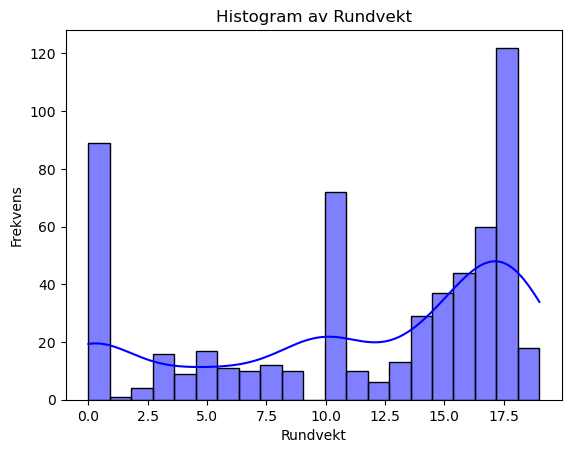

In [ ]:
rundvekt = filtered_train_df[filtered_train_df['Rundvekt']< 20]
sns.histplot(rundvekt['Rundvekt'], kde=True, bins=21, color='blue')
plt.title('Histogram av Rundvekt')
plt.xlabel('Rundvekt')
plt.ylabel('Frekvens')
plt.show()

## 1.5: Gruppere data og fjerne noen kolonner:
Vi har valgt å gruppere data etter aktiviteter etter å ha sett igjennom data først. Man kan argumentere for at det ville vært lurt å gjort det før i prosjektet, men mulige utfordringer da er å ikke kunne fange opp nyansene i datasettet. 

Ved å starte med å inspisere datasettet, har vi lært at for hver fiskeaktivitet så er det registrert flere arter og rundvekt av hver art, selv om hovedarten er den samme. Dersom man ikke har et bilde av hvordan fordelingen av rundvekt er, så kan man senere få utfordringer med modellen. Vi er her bevisste på at når vi slår disse registreringene av rundvekt sammen, så beregner vi også rundvekten for hele fangsten ikke bare rundvekten av hovedarten.

Vi har gjort en antakelse om at total rundvekt kan gi oss en pekepinn på hva en god fangst er, uavhengig av hvilke arter som er fanget. Kanskje er målrettet fiske i realiteten mer lønnsomt, men når man fisker med trål så er mangfoldet av arter som man fanger en del av bildet og gir en større total rundvekt.

Skal man predikere fangst basert på redskapet trål, så blir det altså, gitt omfanget av oppgaven, naturlig å regne rundvekt basert på hele fangsten, men med fokus på en bestemt art.



In [ ]:
# Funksjon for å samle de sammenslåtte dataene som tekststreng.
def join_unique_values(series):
    return ', '.join(series.dropna().astype(str).unique())

grouped_df = filtered_train_df.groupby(['Melding ID', 'Meldingstidspunkt'], as_index=False).agg({
    'Melding ID': 'first', # Trengs muligens for å skille aktiviterer fra ulike båter.
    'Meldingstidspunkt': 'first', 
    'Meldingsdato': 'first',
    'Meldingsklokkeslett': 'first', 
    'Starttidspunkt': 'first', 
    'Startdato': 'first',
    'Startklokkeslett': 'first', 
    'Startposisjon bredde': 'first', 
    'Startposisjon lengde': 'first',
    'Hovedområde start (kode)': 'first', 
    #'Hovedområde start': 'first',  # Vi forholder oss til koden, da blir denne kolonnen irrelevant
    #'Lokasjon start (kode)': 'first', # Mye tomme celler, dokumentasjonen advarer om å bruke denne kolonnen.
    'Havdybde start': 'first', 
    'Stopptidspunkt': 'first', 
    'Stoppdato': 'first', 
    'Stoppklokkeslett': 'first', 
    'Varighet': 'first', 
    #'Fangstår': 'first', Så og si alle fangstdata er registrert i 2018.
    'Stopposisjon bredde': 'first', 
    'Stopposisjon lengde': 'first',
    # 'Hovedområde stopp (kode)': 'first', # Vi forholder oss til området hvor fisket starter. 
    #'Hovedområde stopp': 'first', 
    #'Lokasjon stopp (kode)': 'first', # Unødvendig å ha med videre.
    'Havdybde stopp': 'first', 
    'Trekkavstand': 'first',
    #'Redskap FAO (kode)': 'first', # Unødvendig med flere kolonner av redskaper
    #'Redskap FAO': 'first', 
    #'Redskap FDIR (kode)': 'first',
    'Redskap FDIR': 'first', # Vi forholder oss FDIR sine kolonner av redskaper.
    #'Hovedart FAO (kode)': 'first', 
    'Hovedart FAO': 'first',
    #'Hovedart - FDIR (kode)': 'first', 
    #'Art FAO (kode)': join_unique_values, # Sletter bifangst radene, siden vi ikke er interessert i å se på bifangst. 
    #'Art FAO': join_unique_values,
    #'Art - FDIR (kode)': join_unique_values, 
    #'Art - FDIR': join_unique_values, 
    #'Art - gruppe (kode)': 
    #'Art - gruppe': 'Join_unique_values' 
    'Rundvekt': 'sum', # Summerer sammen fangsten på en aktivitet.
    'Lengdegruppe (kode)': 'first', 
    'Lengdegruppe': 'first',
    'Bruttotonnasje 1969': 'first', 
    'Bruttotonnasje annen': 'first', 
    'Bredde': 'first',
    'Fartøylengde': 'first'
    })

grouped_df.head()

,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),...,Trekkavstand,Redskap FDIR,Hovedart FAO,Rundvekt,Lengdegruppe (kode),Lengdegruppe,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
0,1497341,01.01.2018 23:30,01.01.2018,23:30,01.01.2018 18:54,01.01.2018,18:54,61.283,2.074,28.0,...,16590.0,Bunntrål,Sei,3000.0,5.0,28 m og over,2053.0,NaN,13.00,75.50
1,1497435,02.01.2018 07:50,02.01.2018,07:50,01.01.2018 03:21,01.01.2018,03:21,68.256,10.828,5.0,...,43775.0,Bunntrål,Sei,39816.0,5.0,28 m og over,2580.0,NaN,14.60,64.00
2,1497823,02.01.2018 23:31,02.01.2018,23:31,02.01.2018 00:20,02.01.2018,00:20,68.535,11.986,5.0,...,35125.0,Bunntrål,Sei,16547.0,5.0,28 m og over,2580.0,NaN,14.60,64.00
3,1497827,02.01.2018 23:31,02.01.2018,23:31,02.01.2018 21:48,02.01.2018,21:48,69.483,15.850,5.0,...,4006.0,Bunntrål,Sei,5190.0,4.0,"21-27,99 m",NaN,129.0,7.01,25.07
4,1497843,02.01.2018 23:45,02.01.2018,23:45,02.01.2018 16:52,02.01.2018,16:52,63.122,5.381,7.0,...,34192.0,Bunntrål,Sei,1685.0,5.0,28 m og over,536.0,NaN,10.30,33.95


## 1.6: Utforske datasettet på nytt
Etter at vi har gått gjennom datasettet og gjort en del filtreringer, har vi nå spisset videre arbeid mot en bestemt art, et bestemt redskap og en bestemt lokasjon. Vi ønsker da å utforske det filtrerte datasettet på nytt for å se om vi kan gjøre interessante oppdagelser som kan brukes videre. Vi vil også forsøke å gruppere data der det er fordelaktig, og videre redusere overflødig/gjentakende data.

I følge Müller & Guido (2017) er den beste måten å utforske datasettet på å visualisere dataene. Vi vil i tillegg forsøke å gruppere dataene for 

-- HVA GJØR VI HER? --

### 1.6.1 Rundvekt

/opt/homebrew/anaconda3/envs/info284/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


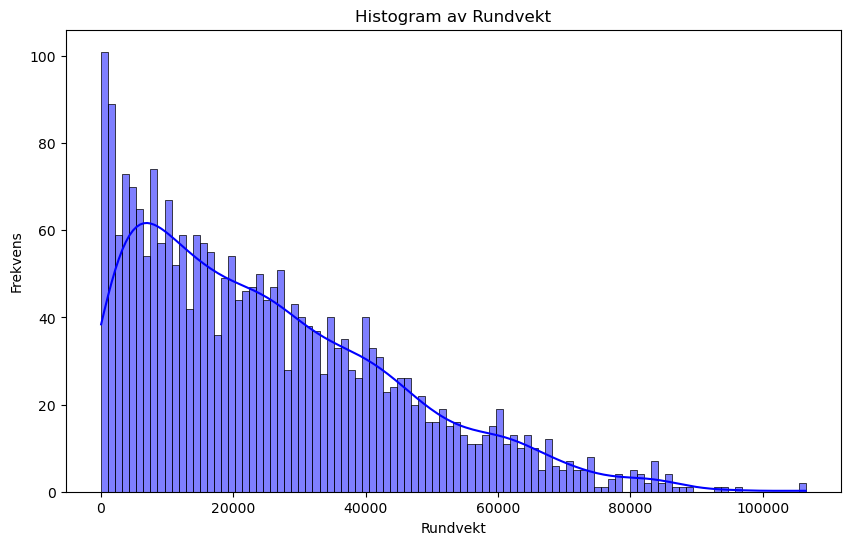

In [ ]:
import seaborn as sns

# Ser på fordelingen av rundvekt.
plt.figure(figsize=(10, 6))
sns.histplot(grouped_df['Rundvekt'], kde=True, bins=100, color='blue')
plt.title('Histogram av Rundvekt')
plt.xlabel('Rundvekt')
plt.ylabel('Frekvens')
plt.show()

/opt/homebrew/anaconda3/envs/info284/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


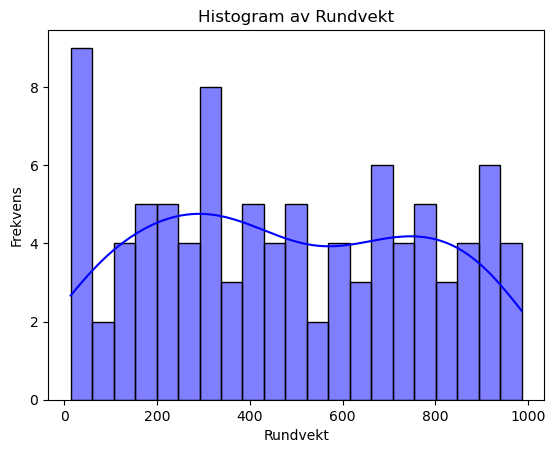

In [ ]:
rundvekt = grouped_df[grouped_df['Rundvekt']< 1000]
sns.histplot(rundvekt['Rundvekt'], kde=True, bins=21, color='blue')
plt.title('Histogram av Rundvekt')
plt.xlabel('Rundvekt')
plt.ylabel('Frekvens')
plt.show()

Det ser her ut til at det eksisterer en del "bomturer" hvor fiskeaktiviteten ikke har gitt fangst. Dette vil vi komme tilbake til når vi skal rense data i punkt 7.

In [ ]:
log_rundvekt = np.log(filtered_train_df['Rundvekt'])
log_rundvekt.skew()

/opt/homebrew/anaconda3/envs/info284/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/info284/lib/python3.10/site-packages/pandas/core/nanops.py:1248: RuntimeWarning: invalid value encountered in subtract
  adjusted = values - mean


nan

### 1.6.2 Bruttotonnasje:
Som tidligere nevnt, eksisterer det to ulike kolonner som inneholder informasjon om båtens bruttotonnasje. Det er vanskelig å vite hvilke mål på skipet som er de beste for å anslå skipets lastekapasitet, men vi har landet på bruttotonnasje som det beste målet. 

For å bruke bruttotonnasje-kolonnene er vi nødt til å kombinere kolonnene "bruttotonnasje 1969" og "bruttotonnasje annen". I vedlegg til oppgaven står det følgende om bruttotonnasje 1969: "I denne variabelen, «Bruttotonnasje 1969», er det i dag ført bruttotonnasje for fartøy med lengde (L) større eller lik 24 meter (L), målt og berekna i medhald av internasjonal konvensjon om måling av fartøy, 1969 (London-konvensjonen 1969)."

Dette vil si at skip under 24 m er ført i bruttotonnasje annen og de andre i 1969. Vi kan da trygt slå sammen kolonnene siden ingen er registrert på forskjellige måter.

In [ ]:
# Slår sammen bruttotonnasje-gruppene.
grouped_df.loc[:, 'Bruttotonnasje kombinert'] = grouped_df['Bruttotonnasje 1969'].fillna(grouped_df['Bruttotonnasje annen'])

/opt/homebrew/anaconda3/envs/info284/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


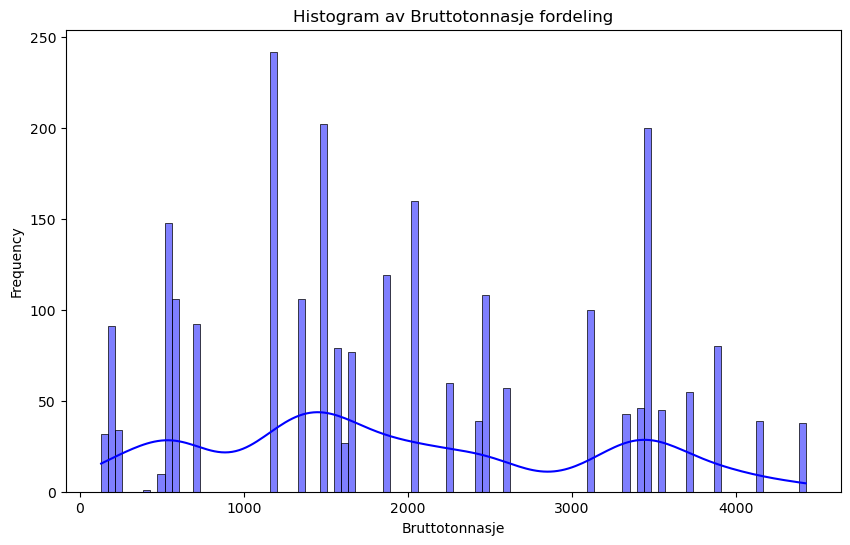

In [ ]:
# Lager grafisk fremstilling av fordeling av båtstørrelse
plt.figure(figsize=(10, 6))
sns.histplot(grouped_df['Bruttotonnasje kombinert'], kde=True, bins=100, color='blue')
plt.title('Histogram av Bruttotonnasje fordeling')
plt.xlabel('Bruttotonnasje')
plt.ylabel('Frequency')
plt.show()

Vi ser her tendenser av at båtstørrelsen deles grovt inn i tre kategorier: Småbåter under 1000 bruttotonn, mellom store mellom 1000 og 3000 og store over 3000. vi velger å gruppere båtene inn i disse tre gruppene.

In [ ]:
# Grupperer Bruttotonnasje-kolonnen
bins = [0, 1000, 2000, 3000, 4000]
labels = [1, 2, 3, 4]
grouped_df['Bruttotonnasje gruppert'] = pd.cut(grouped_df['Bruttotonnasje kombinert'], bins=bins, labels=labels)

grouped_df['Bruttotonnasje gruppert'].value_counts()

Bruttotonnasje gruppert
2    852
4    569
1    514
3    424
Name: count, dtype: int64

### 1.6.3 Valg av kolonne i forhold til tid:
Etter å ha testet de ulike kolonnene hva gjelder fordeling av tid, ser vi at det er veldig mange registreringer på startklokkeslett 00.00

-- SKAL DET STÅ NOE OM ET VALG VI HAR TATT HER? REF OVERSKRIFTEN --


In [ ]:
# Grupperer startklokkeslett i grupper etter timer slik at.
grouped_df['Startklokkeslett'] = pd.to_datetime(grouped_df['Startklokkeslett'], format='%H:%M')
grouped_df['Hours'] = grouped_df['Startklokkeslett'].dt.hour
print(grouped_df['Hours'].value_counts())

# Grupperer meldingsdato etter måneder.
grouped_df['Meldingsdato'] = pd.to_datetime(grouped_df['Meldingsdato'], format='%d.%m.%Y', errors='coerce')
grouped_df['Month'] = grouped_df['Meldingsdato'].dt.month
print(grouped_df['Month'].value_counts())

Hours
23    124
17    118
22    117
10    114
16    114
0     113
11    110
5     109
7     108
13    105
12    104
6     103
15    102
18    102
2      97
21     97
14     96
9      96
3      91
20     89
4      85
19     85
1      81
8      76
Name: count, dtype: int64
Month
3     326
2     316
7     220
9     220
4     198
1     189
12    181
6     175
11    175
8     157
5     150
10    129
Name: count, dtype: int64


### 1.6.4 Månedlig seifiske
Videre undersøker vi månedlig fagst av sei i områdene.

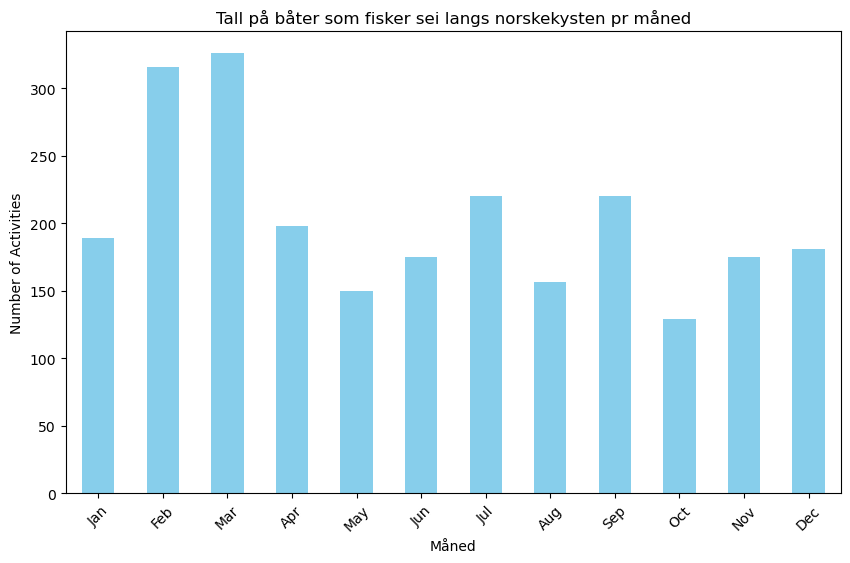

In [ ]:
# Teller månedlig aktivitet.
monthly_counts = grouped_df.groupby('Month').size()

# Oppretter en serie for alle månedene i døgnet
all_months = pd.Series(0, index=range(1, 13))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_months.update(monthly_counts)

# Generer et diagram
plt.figure(figsize=(10, 6))
all_months.plot(kind='bar', color='skyblue')
plt.title(f'Tall på båter som fisker sei langs norskekysten pr måned')
plt.xlabel('Måned')
plt.ylabel('Number of Activities')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()



Vi ser her at det er mer aktivitet rundt seifiske i månedene februar og mars langs norskekysten. Det kan tenkes at dette har sammenheng med lofotfisket som foregår i månedene februar - april. 

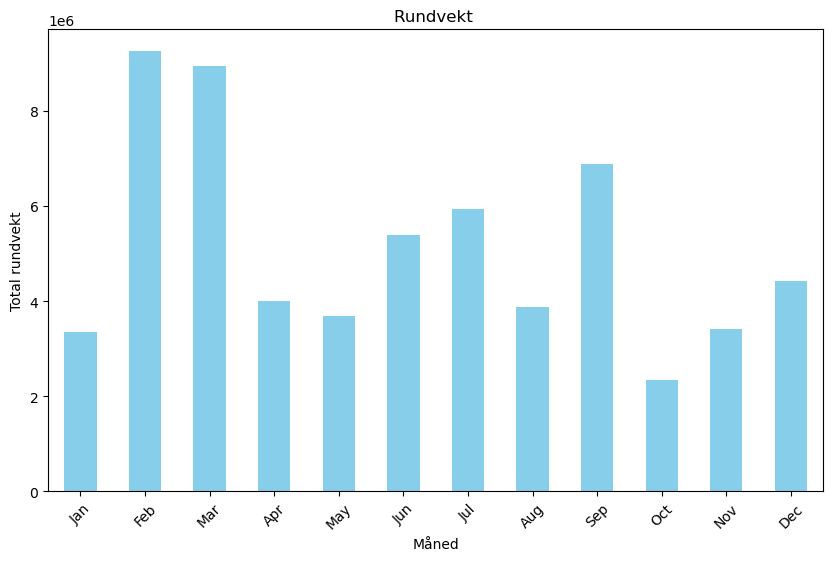

In [ ]:
# Finner månedlig total rundvekt
monthly_weights = grouped_df.groupby('Month')['Rundvekt'].sum()

# Oppretter en serie for alle månedene i døgnet
all_months = pd.Series(0, index=range(1, 13))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_months.update(monthly_weights)

# Generer et diagram
plt.figure(figsize=(10, 6))
all_months.plot(kind='bar', color='skyblue')
plt.title(f'Rundvekt ')
plt.xlabel('Måned')
plt.ylabel('Total rundvekt')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

### 1.6.5 Samlet rundvekt av aktivitetene pr måned
Her ser vi tydelig sammenheng mellom månedene med stor aktivitet og den samlede rundvekten av aktivitetene.

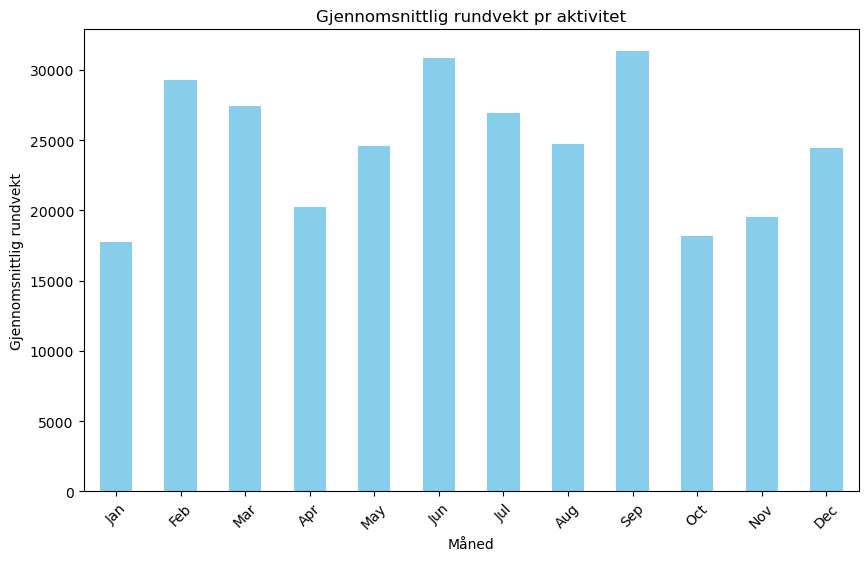

In [ ]:
# Regner ut gjenomsnitt pr time
average_weights = monthly_weights/monthly_counts

# Oppretter en serie for alle timene i døgnet
all_months = pd.Series(0, index=range(1, 13))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_months.update(average_weights.astype(int))

# Generer et diagram
plt.figure(figsize=(10, 6))
all_months.plot(kind='bar', color='skyblue')
plt.title(f'Gjennomsnittlig rundvekt pr aktivitet')
plt.xlabel('Måned')
plt.ylabel('Gjennomsnittlig rundvekt')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

Ser her av gjennomsnittlig vekt at seifiske virker å være stabilt i den forstand at den forventede fangsten holder seg ganske stabil gjennom året.
September utmerker seg likevel som en måned hvor det er er forventet mer fisk.

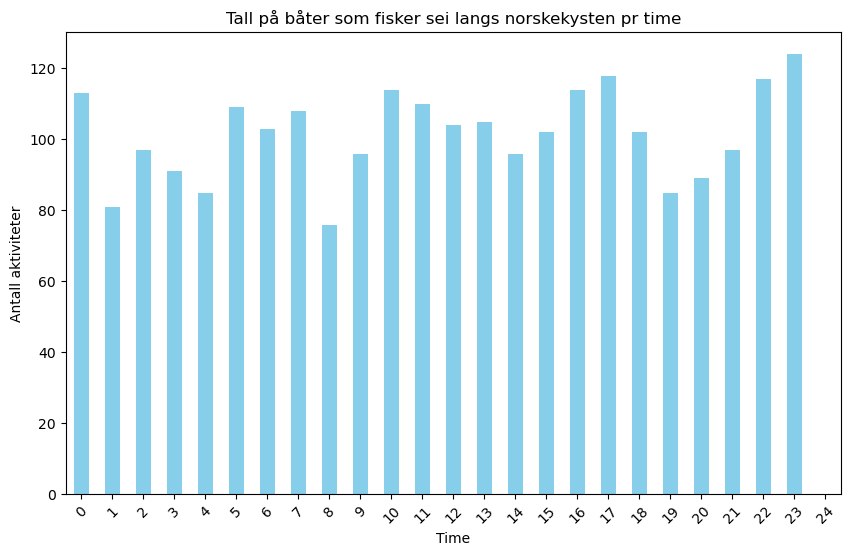

In [ ]:
# Regner ut gjenomsnitt pr time
hourly_counts = grouped_df.groupby('Hours').size()

# Oppretter en serie for alle timene i døgnet
all_hours = pd.Series(0, index=range(0, 25))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_hours.update(hourly_counts)

# Generer et diagram
plt.figure(figsize=(10, 6))
all_hours.plot(kind='bar', color='skyblue')
plt.title(f'Tall på båter som fisker sei langs norskekysten pr time')
plt.xlabel('Time')
plt.ylabel('Antall aktiviteter')
plt.xticks(range(25), [x for x in range (0,25)], rotation=45)
plt.show()


Her ser vi hvordan fiskeaktivitetene av sei varierer i løpet av døgnet. Ser at det er en nokså stabil aktivitet gjennom døgnet. Her hadde vi forventet litt variasjoner.

Det finner det videre interessant å se på forholdet mellom aktivitetene og fangsten.

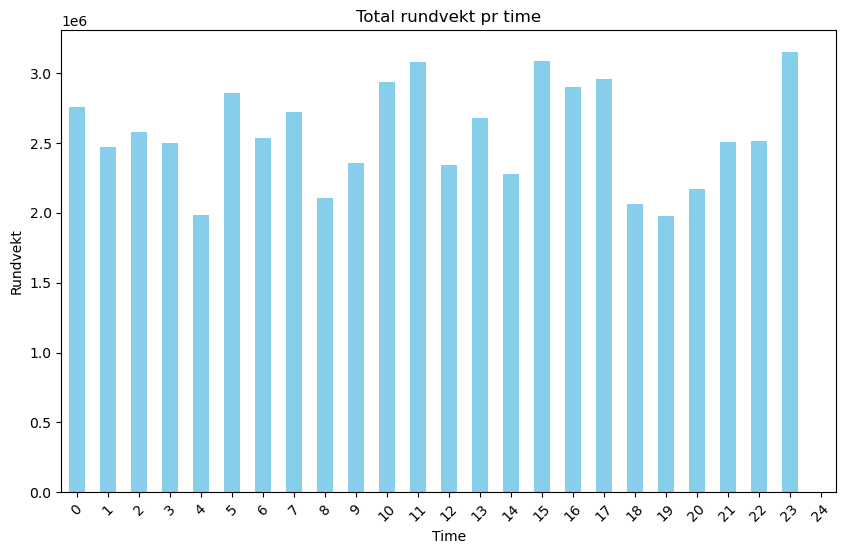

In [ ]:
# Regner ut gjenomsnitt pr time
hourly_weights = grouped_df.groupby('Hours')['Rundvekt'].sum()

# Oppretter en serie for alle timene i døgnet
all_hours = pd.Series(0, index=range(0, 25))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_hours.update(hourly_weights)

# Generer et diagram
plt.figure(figsize=(10, 6))
all_hours.plot(kind='bar', color='skyblue')
plt.title(f'Total rundvekt pr time')
plt.xlabel('Time')
plt.ylabel('Rundvekt')
plt.xticks(range(25), [x for x in range (0,25)], rotation=45)
plt.show()

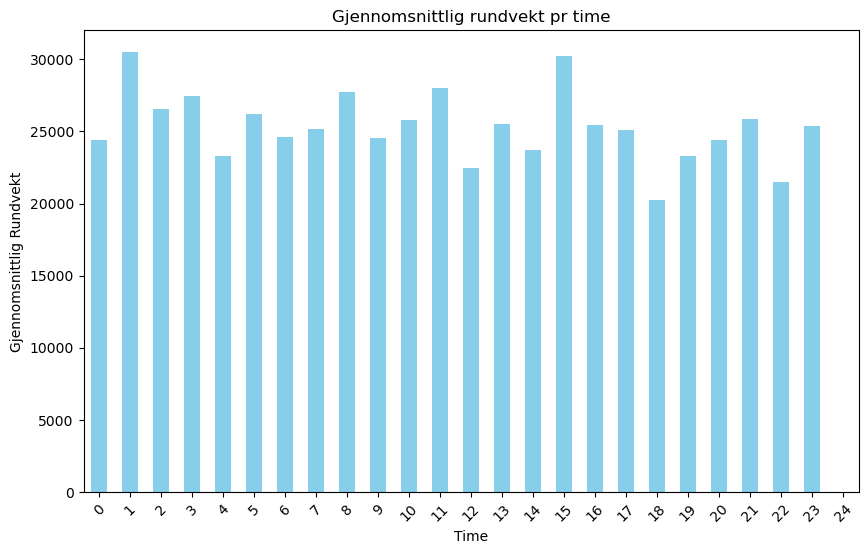

In [ ]:
# Regner ut gjenomsnitt pr time
hourly_average = hourly_weights/hourly_counts

# Oppretter en serie for alle timene i døgnet
all_hours = pd.Series(0, index=range(0, 25))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_hours.update(hourly_average.astype(int))

# Generer et diagram
plt.figure(figsize=(10, 6))
all_hours.plot(kind='bar', color='skyblue')
plt.title(f'Gjennomsnittlig rundvekt pr time')
plt.xlabel('Time')
plt.ylabel('Gjennomsnittlig Rundvekt')
plt.xticks(range(25), [x for x in range (0,25)], rotation=45)
plt.show()

### 1.6.6 Tolking av data:
Det ser ut som seifisket med bunntrål fordeler seg ganske jevnt ut over døgnet og året, men med litt mer variasjon i løpet av året. Den beste fangsmåneden ser ut til å være i september om man ser på gjennomsnittlig fangst. Om noe forskjell i løpet av døgnet, så ser det ut som det det blir fanget noe mer fisk fra rundt midnatt til og med kl 11. 

Selv om det er lite variasjoner på døgnet, kan det likevel være relevant for å predikere fiske. Det kan tenkes at det kan skyldes at fiske i nordlige deler på sommer eller vinterhalvåret gir naturlig en jevnere fordeling ila døgnet, siden forskjellene på natt og dag er mindre. Kanskje ville disse forskjellene være tydeligere i mer sørlige områder.


In [ ]:
# Se på tid-kolonnene:   Check
    # Binne tid på døgnet   Chekc
    # Binne måneder    Check
# Se på statistikk: Check
# Gjøre om dato og tid til
# Fangst pr vektklasse - diagram
# Fangst pr område - diagram
# Fangst pr tid på døgnet
# Fangst pr årstid


### 1.6.7 Omforming av tid

In [ ]:
grouped_df.Stoppklokkeslett.value_counts()

Stoppklokkeslett
22:16    9
00:10    8
01:05    7
00:01    7
00:03    7
        ..
01:24    1
17:51    1
09:19    1
15:50    1
00:44    1
Name: count, Length: 1168, dtype: int64

Om man skal bruke tid på døgnet må vi omforme dataene litt.
Maskinen og modellene vil tolke 00.01 og 23.59 som to verdier som er veldig langt ifra hverandre. Ved å omregne til sinus/radian, så kan vi løse dette. Da får vi mer "sykliske" data.

In [ ]:
grouped_df['Startklokkeslett'] = pd.to_datetime(grouped_df['Startklokkeslett'], format='%H:%M').dt.strftime('%H-%M')
# Konverter til Desimal-timer.
grouped_df['Startklokkeslett_DecimalHours'] = grouped_df['Startklokkeslett'].str.split('-').apply(lambda x: int(x[0]) + int(x[1]) / 60)
# Konverter til Radianer.
grouped_df['Startklokkeslett_Radians'] = grouped_df['Startklokkeslett_DecimalHours'] * (2 * np.pi / 24)
grouped_df.head()

,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),...,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde,Bruttotonnasje kombinert,Bruttotonnasje gruppert,Hours,Month,Startklokkeslett_DecimalHours,Startklokkeslett_Radians
0,1497341,01.01.2018 23:30,2018-01-01,23:30,01.01.2018 18:54,01.01.2018,18-54,61.283,2.074,28.0,...,2053.0,NaN,13.00,75.50,2053.0,3,18,1,18.900000,4.948008
1,1497435,02.01.2018 07:50,2018-01-02,07:50,01.01.2018 03:21,01.01.2018,03-21,68.256,10.828,5.0,...,2580.0,NaN,14.60,64.00,2580.0,3,3,1,3.350000,0.877028
2,1497823,02.01.2018 23:31,2018-01-02,23:31,02.01.2018 00:20,02.01.2018,00-20,68.535,11.986,5.0,...,2580.0,NaN,14.60,64.00,2580.0,3,0,1,0.333333,0.087266
3,1497827,02.01.2018 23:31,2018-01-02,23:31,02.01.2018 21:48,02.01.2018,21-48,69.483,15.850,5.0,...,NaN,129.0,7.01,25.07,129.0,1,21,1,21.800000,5.707227
4,1497843,02.01.2018 23:45,2018-01-02,23:45,02.01.2018 16:52,02.01.2018,16-52,63.122,5.381,7.0,...,536.0,NaN,10.30,33.95,536.0,1,16,1,16.866667,4.415683


## 1.7: Slette kolonner
Datasettet vi arbeider med inneholder en stor mengde overflødig eller gjentakende informasjon som ikke er relevant videre. Vi har blant annet sett at informasjon om bruttotonnasje er fordelt på to kolonner. Vi har tidligere opprettet en ny kolonne hvor verdiene i disse to er kombinert. Vi kan dermed filtrere bort de opprinnelige kolonnene for bruttotonnasje videre. 

Videre finnes det også kolonner hvor dataene ikke er relevante for oss. Dette gjelder blant annet tidspunkt for når meldingen er registrert, som ikke brukes til å predikere fiske i dette tilfellet, da meldingen kan ha vært sendt på et helt annet tidspunkt enn når fisket er gjennomført. Vi er altså interessert i faktisk tidspunkt og posisjon for fisket for å kunne si noe om resultater fra fisket.

Kolonner vi ikke ser som aktuelle å bruke videre vil nå slettes.


In [ ]:
grouped_df.columns


Index(['Melding ID', 'Meldingstidspunkt', 'Meldingsdato',
       'Meldingsklokkeslett', 'Starttidspunkt', 'Startdato',
       'Startklokkeslett', 'Startposisjon bredde', 'Startposisjon lengde',
       'Hovedområde start (kode)', 'Havdybde start', 'Stopptidspunkt',
       'Stoppdato', 'Stoppklokkeslett', 'Varighet', 'Stopposisjon bredde',
       'Stopposisjon lengde', 'Havdybde stopp', 'Trekkavstand', 'Redskap FDIR',
       'Hovedart FAO', 'Rundvekt', 'Lengdegruppe (kode)', 'Lengdegruppe',
       'Bruttotonnasje 1969', 'Bruttotonnasje annen', 'Bredde', 'Fartøylengde',
       'Bruttotonnasje kombinert', 'Bruttotonnasje gruppert', 'Hours', 'Month',
       'Startklokkeslett_DecimalHours', 'Startklokkeslett_Radians'],
      dtype='object')

In [ ]:

# Dropper kolonner: Vi hasher ut de kolonnene vi vil beholde.
grouped_df = grouped_df.drop(columns=[
    'Melding ID', 
    'Meldingstidspunkt', 
    'Meldingsdato', 
    'Meldingsklokkeslett', 
    'Starttidspunkt', 
    'Startdato', 
    'Startklokkeslett', # har konvertert
    #'Startposisjon bredde', 
    #'Startposisjon lengde', 
    'Hovedområde start (kode)', 
    #'Havdybde start', 
    'Stopptidspunkt', # Vi antar at det er liten forskjell på start og sluttidspunkt, så vi velger å droppe disse.
    'Stoppdato', 
    'Stoppklokkeslett', 
    'Varighet', 
    'Stopposisjon bredde', 
    'Stopposisjon lengde', 
    #'Havdybde stopp', Kan være interessant å se på senere
    #'Trekkavstand', 
    #'Redskap FDIR', 
    #'Hovedart - FDIR (kode)', 
    #'Rundvekt', 
    'Lengdegruppe (kode)', 
    'Lengdegruppe', 
    'Bruttotonnasje 1969', 
    'Bruttotonnasje annen', 
    'Bredde', 
    'Fartøylengde', 
    #'Bruttotonnasje kombinert', 
    # Bruttotonnasje gruppert,
    'Hours', 
    #'Month', Tar med måned videre.
    #'Startklokkeslett_DecimalHours',
    #'Startklokkeslett_Radians'
    ])

grouped_df.describe()

,Startposisjon bredde,Startposisjon lengde,Havdybde start,Havdybde stopp,Trekkavstand,Rundvekt,Bruttotonnasje kombinert,Month,Startklokkeslett_DecimalHours,Startklokkeslett_Radians
count,2436.000000,2436.000000,2436.000000,2436.000000,2436.000000,2436.000000,2436.000000,2436.000000,2436.000000,2436.000000
mean,67.009345,13.557950,-195.510673,-199.232759,13698.599754,25249.108785,1955.658867,5.974548,12.244985,3.205730
std,4.110166,8.422848,71.029955,75.574104,11281.269592,19673.331632,1154.008761,3.477025,6.945426,1.818308
min,60.003000,2.018000,-761.000000,-1252.000000,0.000000,14.000000,129.000000,1.000000,0.000000,0.000000
25%,62.931750,5.384000,-230.250000,-235.000000,5189.250000,9017.750000,1194.000000,3.000000,6.312500,1.652609
50%,69.350000,15.767000,-187.000000,-188.000000,10366.500000,21342.000000,1648.000000,6.000000,12.291667,3.217951
75%,70.863250,20.655500,-152.000000,-152.000000,19770.750000,37602.750000,3104.000000,9.000000,18.083333,4.734206
max,71.998000,32.279000,1.000000,-49.000000,138228.000000,106517.000000,4427.000000,12.000000,23.983333,6.278822


## 1.8: Rense nullverdier og ekstremer
Nullverdier.

Av df.describe leser vi først max og min verdier for å se om det er noen ekstreme eller usannsynlige verdier.
Rundvekt, 0 - registreringer. Ser at det er registreringer med verdien 0 i trekkavstand og rundvektkolonnen. Vi anser dette som feilregistreringer. Av trålens natur, at den soper store havområder, ser vi det som lite trolig at rundvekt 0 skal forekomme. Videre kan vi anta at registreringer med 0 i trekkavstand også er lite sannsynlig. 

Trekkavstand:
Vi ser at det ligger registreringer på over 200000 meter, det vil si 200 km eller 20 mil. Dette er store avstander for en trål som vanligvis opererer i snittfart på mellom 3,4 (6,3km/h) og 5 knop (9,26 km/h). I en snittfart på 10km/h så vil da trålen bruke over 20 timer. Med så lang varighet vil det være svært ugunstige forhold for fisken. 
Vi ser også at 5% av registreringene er over 35446m. Her ser vi også at med relativt høy fart, vil aktiviteten ha varighet på nærmere 4 timer. Ved å kutte registreringer over 50000 gir det oss en god margin på mulige feilregistreringer.

Dybde:
Vi ser det er registrert positive havdybde-verdier, i tillegg er det også registrert aktiviteter på -1276 dybde. Men de aller fleste aktivitetene er registrert mellom -227 og -145 meter. Fiskeridirektoratet beskriver at "Sei førekjem både pelagisk og som botnfisk, frå 0 til 300 meters djup." (https://www.hi.no/hi/temasider/arter/nordaustarktisk-sei) Vi mener det er sannsynlig at dette er enten en feilregistrering eller at fangsten er gjort når trålen er på vei opp av dypet. 



Ser av trekkavstand at det i 0-registreringene av trekkavstand også fanges fisk. Dette gir ikke mening med tanke på at det følgelig må trekkes en viss avstand for å få fisk.

Ser også her at det er registrert forskjellige arter i 0-registrerningene på rundvekt. Det er da fornuftig å anta at dette enten er feilregistreringer eller fangst uten betydning.

In [ ]:
# Får oversikt av de ulike verdiene:

In [ ]:
# Fjerner radene med data nevnt over:
# Droppe tomme rader.
cleaned_df = grouped_df.copy().dropna()
# Konvertere positive Havdybdeverdier
cleaned_df['Havdybde stopp'] = cleaned_df['Havdybde stopp'].abs()
# Ta vekk havdybder på over 10 m, for å fjerne usannsynlige tråledybder.
cleaned_df = cleaned_df[cleaned_df['Havdybde stopp'] > 10]
# Droppe trekkavstand på over 50000 m.
cleaned_df = cleaned_df[(cleaned_df['Trekkavstand'] > 0) & (cleaned_df['Trekkavstand'] < 50000)]
# Her kan vi kanskje undersøke

# Droppe ekstreme Bruttotonnasjeverdier.
cleaned_df = cleaned_df[(cleaned_df['Bruttotonnasje kombinert'] > 400) & (cleaned_df['Bruttotonnasje kombinert'] < 4000)]
# Droppe registreringer i områder som ikkje er i Norsk farvatn. Startposisjon med mindre enn 0.
cleaned_df = cleaned_df[cleaned_df['Startposisjon lengde'] > 0]
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2190 entries, 0 to 2435
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Startposisjon bredde           2190 non-null   float64 
 1   Startposisjon lengde           2190 non-null   float64 
 2   Havdybde start                 2190 non-null   int64   
 3   Havdybde stopp                 2190 non-null   int64   
 4   Trekkavstand                   2190 non-null   float64 
 5   Redskap FDIR                   2190 non-null   object  
 6   Hovedart FAO                   2190 non-null   object  
 7   Rundvekt                       2190 non-null   float64 
 8   Bruttotonnasje kombinert       2190 non-null   float64 
 9   Bruttotonnasje gruppert        2190 non-null   category
 10  Month                          2190 non-null   int32   
 11  Startklokkeslett_DecimalHours  2190 non-null   float64 
 12  Startklokkeslett_Radians       2190 non

Endre format på kolonnene til riktig format:
Her ser vi at 

Ser av value_counts at de mest vanlige redskapene er bunntrål og snurrevad. Her er det så mye data at vi fokuserer videre på dette. (Usikker på å inkludere snurrevad.

df['Redskap

# 2: Supervised learning

## 2.1: KNN
Vi har valgt å bygge en KNNClassifier, for å klassifisere fangsten. Når vi bruker en klassifiseringsmodell. Vi vil prøve å skalere dataene.

KNN kan beskrives som den enkleste maskinlæringsmodellen. For å gjøre antakelsen(prediction) ser den kun etter det nærmeste punktet til startspunktet. Altså den nærmeste naboen i treningssettet. Dette er den enkleste versjonen av modellen, men man kan videre justere den til å se på et større antall av de nærmeste naboene, altså k antall naboer. Dette vil i teorien gjøre modellen mer nøyaktig.

Ulemper: Siden modellen er såpass simpel vil presisjonen være varierende. Siden man bare ser etter de nærmeste naboene til et gitt punkt kan man få store variasjoner i "training datasettet" og "test datasettet". 
(og deler igjen training settet inn i to.)

Dette er fordi man kan være "uheldig" med den tilfeldige fordelingen av dataen, og kan ende opp med de ekstreme ytterpunktene i de ulike settene.

Derfor har vi (som nevnt tidligere) i preprosseseringen av dataen vår valgt å fjerne ekstremer/ytterpunkter i datasettet, ettersom det kan se ut til å eksistere en del feilregistreringer som vil kunne gi uheldige resultater når vi skal bygge maskinlæringsmodellene. Dette vil også gi et jevnere utvalg. Ved å ekskludere denne dataen vil vi kunne få et mer presist svar. (dog på bekostning av mindre data modellen kan se på.)

Fordeler: Fordeler med KNN er at den er enkel å forstå og gir generelt relativt gode resultater uten å måtte justere for mye. Det er også en fin start i prosessen videre før vi innfører flere og mer kompliserte maskinlæringsmodeller.

In [ ]:
cleaned_df.columns

Index(['Startposisjon bredde', 'Startposisjon lengde', 'Havdybde start',
       'Havdybde stopp', 'Trekkavstand', 'Redskap FDIR', 'Hovedart FAO',
       'Rundvekt', 'Bruttotonnasje kombinert', 'Bruttotonnasje gruppert',
       'Month', 'Startklokkeslett_DecimalHours', 'Startklokkeslett_Radians'],
      dtype='object')

In [ ]:
# Lager kolonne som tar ser om trålen dras i oppoverbakke eller nedoverbakke.
cleaned_df['havdybde differanse'] = cleaned_df['Havdybde start'].abs()-cleaned_df['Havdybde stopp']
#cleaned_df['Startposisjon bredde'] = cleaned_df['Stopp']
cleaned_df['havdybde differanse'].value_counts()

havdybde differanse
 0      49
 4      44
-1      43
-4      37
-8      36
        ..
-243     1
-189     1
 90      1
-160     1
-102     1
Name: count, Length: 301, dtype: int64

In [ ]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2190 entries, 0 to 2435
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Startposisjon bredde           2190 non-null   float64 
 1   Startposisjon lengde           2190 non-null   float64 
 2   Havdybde start                 2190 non-null   int64   
 3   Havdybde stopp                 2190 non-null   int64   
 4   Trekkavstand                   2190 non-null   float64 
 5   Redskap FDIR                   2190 non-null   object  
 6   Hovedart FAO                   2190 non-null   object  
 7   Rundvekt                       2190 non-null   float64 
 8   Bruttotonnasje kombinert       2190 non-null   float64 
 9   Bruttotonnasje gruppert        2190 non-null   category
 10  Month                          2190 non-null   int32   
 11  Startklokkeslett_DecimalHours  2190 non-null   float64 
 12  Startklokkeslett_Radians       2190 non

In [ ]:
all_features = ['Startklokkeslett', 'Bruttotonnasje gruppert', 'Trekkavstand', 'Havdybde stopp', 'Hours', 'Month', 'Rundvekt', 'havdybde differanse']
target = ['Rundvekt']

plot_frame = cleaned_df[all_features]  # Append 'Rundvekt' to include it in the DataFrame for plotting

# Generate the scatter matrix plot
grr = pd.plotting.scatter_matrix(
    plot_frame, c=plot_frame['Rundvekt'], figsize=(15, 15), marker='o', hist_kwds={'bins':40}, s=60, alpha=.8
    )

KeyError: "['Startklokkeslett', 'Hours'] not in index"

### Scaling:
#### Logaritmisk:
Vi ser at rundvekt er fordelt logaritmisk - den har en "skihopp form.
Log-skalering:
    rundvekt
    trekkavstand
#### normalfordelt:
    - Havdybde differanse
    - havdybde

Dette gjelder også trekkavstand.
Prøver å skalere disse kolonnene:

Ser utifra denne ploten at vi fremdelse har noen ekstremverdier som vi kan luke ut.
Rundvekt på over 70000 har vi bare to registreringer av. Selv om det sikkert er reelle registreringer, så vurderer vi det klokt å fjerne.

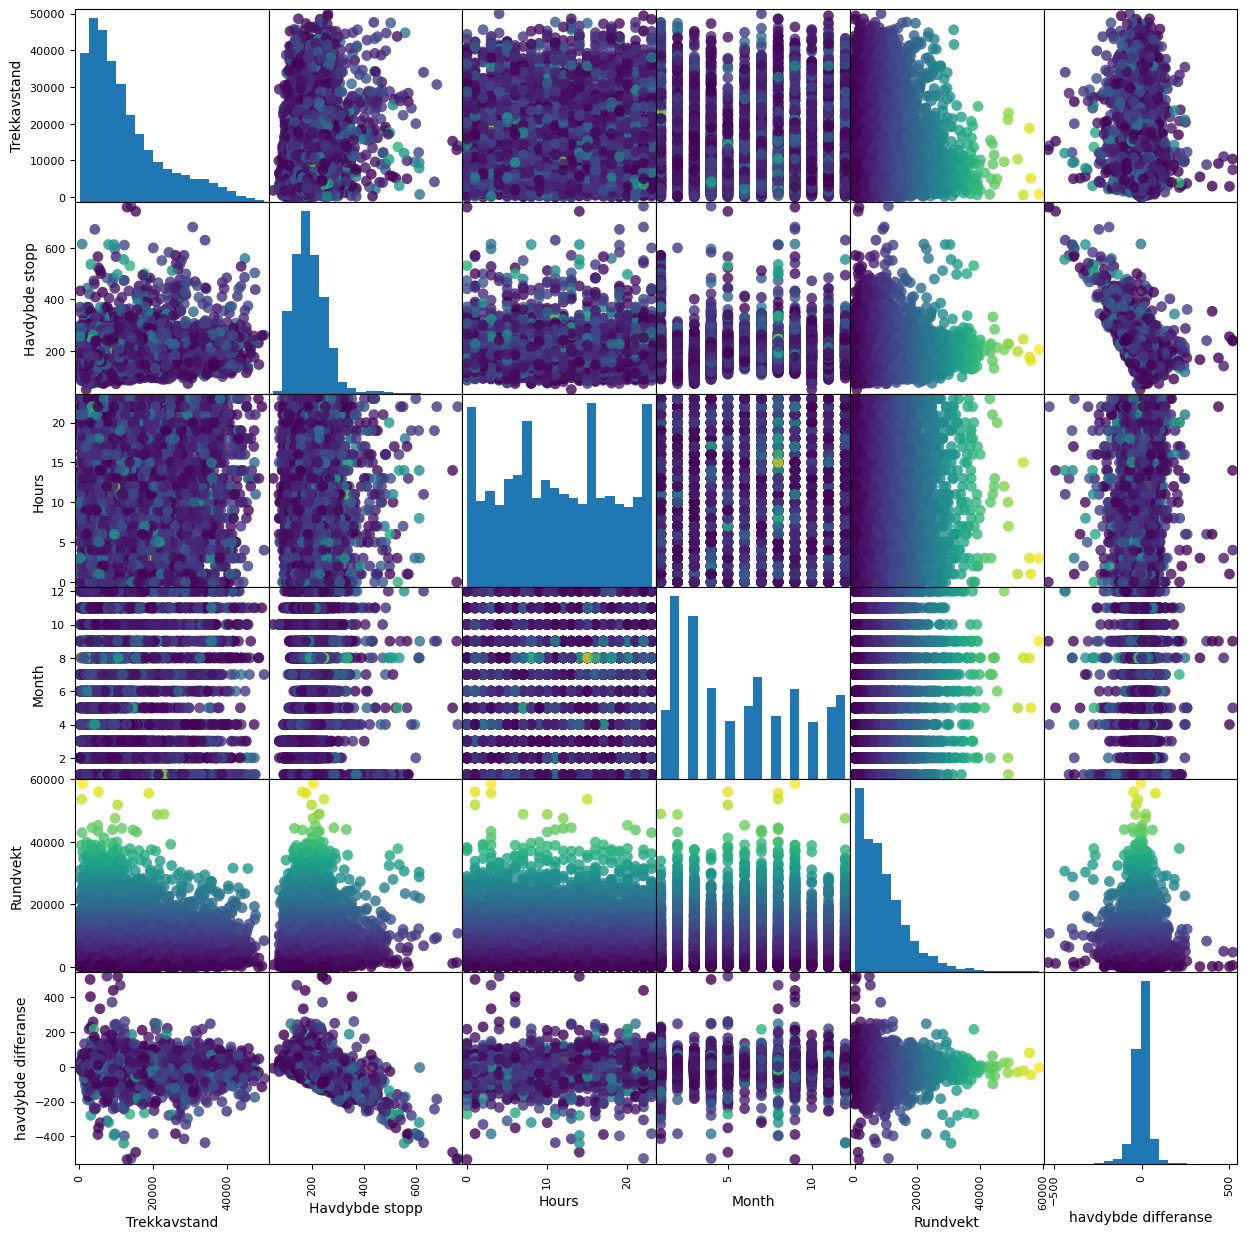

In [ ]:
cleaned_df = cleaned_df[cleaned_df['Rundvekt'] < 70000]
plot_frame = cleaned_df[all_features] 
grr = pd.plotting.scatter_matrix(
    plot_frame, c=plot_frame['Rundvekt'], figsize=(15, 15), marker='o', hist_kwds={'bins':20}, s=60, alpha=.8
    )


In [ ]:
# Step 3: Implement binning
labels = ['bad catch', 'Below Average', 'Above average', 'Good catch']

In [ ]:
# Binne target etter den logaritmiske kurven.
cleaned_df['log_Rundvekt'] = np.log1p(cleaned_df['Rundvekt'])  # Log-transform
cleaned_df['binned'] = pd.cut(cleaned_df['log_Rundvekt'], bins=4, labels=labels)
cleaned_df['binned'].value_counts()

binned
Good catch       4557
Above average    1665
Below Average     262
bad catch          12
Name: count, dtype: int64

In [ ]:
num_bins = 4  # For example, to create quartiles
labels = ['Q1', 'Q2', 'Q3', 'Q4']  # Labels for quartiles
cleaned_df['Q-binned'] = pd.qcut(cleaned_df['Rundvekt'], q=num_bins, labels=labels)
cleaned_df['Q-binned'].value_counts()

Q-binned
Q1    1640
Q3    1624
Q4    1624
Q2    1608
Name: count, dtype: int64

In [ ]:
# Kalkulerer gjennomsnittsrundvekten.
mean_catch_weight = cleaned_df['Rundvekt'].mean()
# Finner standardavviket.
std_dev_catch_weight = cleaned_df['Rundvekt'].std()

# Definerer bins, basert på standardavvik.
lower_bound = mean_catch_weight - 0.65*std_dev_catch_weight
upper_bound = mean_catch_weight + 1.5*std_dev_catch_weight


cleaned_df['fiske-kategori'] = pd.cut(cleaned_df['Rundvekt'], 
                                      bins=[-np.inf, lower_bound, mean_catch_weight, upper_bound, np.inf], 
                                      labels=labels)

print(std_dev_catch_weight)
print(mean_catch_weight)

# Display the first few rows to verify the binning
cleaned_df[['fiske-kategori']].value_counts()

7548.709139958469
8731.647013546799


fiske-kategori
Q3                2117
Q1                1955
Q2                1884
Q4                 540
Name: count, dtype: int64

In [ ]:
all_features = ['Startklokkeslett', 'Trekkavstand', 'Havdybde stopp', 'Hours', 'Month', 'Rundvekt', 'Bruttotonnasje kombinert', 'Startposisjon bredde', 'Startposisjon lengde']
features = ['Trekkavstand', 'Havdybde stopp', 'Startposisjon lengde', 'Startposisjon bredde', 'Bruttotonnasje kombinert']
target = 'fiske-kategori'
X = cleaned_df[features]
y = cleaned_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
# Scale features (for kNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)  # Use transform, not fit_transform

# KNN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=4)
knn_classifier.fit(X_train_scaled, y_train_encoded)
y_pred_knn_classifier = knn_classifier.predict(X_test_scaled)

# Evaluate the classifier
accuracy = accuracy_score(y_test_encoded, y_pred_knn_classifier)
print(f"KNN Classifier Accuracy: {accuracy}")
print(f'kNN Classifier Score {knn_classifier.score(X_test_scaled, y_test_encoded)}')

KNN Classifier Accuracy: 0.32769230769230767
kNN Classifier Score 0.32769230769230767


## 2.2 Desicion tree regressor
Decision trees er en supervised læringsmodell som bade blir brukt til klassifikasjon og regresjon. Den fungerer ved at den stiller en rekke «hvis/hvis ikke-spørsmål» for å komme fram til en «beslutning», altså en klasse eller en verdi (Müller & Guido, 2017). 

In [ ]:
cleaned_df.head()

,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),Hovedområde start,Havdybde start,Havdybde stopp,Trekkavstand,Redskap FDIR,Hovedart - FDIR (kode),...,Bruttotonnasje gruppert,Hours,Month,Startklokkeslett_DecimalHours,Startklokkeslett_Radians,havdybde differanse,log_Rundvekt,binned,Q-binned,fiske-kategori
0,18-54,61.283,2.074,28.0,Vikingbanken,-182,180,16590.0,Bunntrål,1032.0,...,3,18,1,18.900000,4.948008,2,8.006701,Above average,Q1,Q1
1,18-10,68.261,10.842,5.0,Røstbanken til Malangsgrunnen,-385,558,44790.0,Bunntrål,1032.0,...,3,18,1,18.166667,4.756022,-173,10.064798,Good catch,Q4,Q4
2,03-21,68.256,10.828,5.0,Røstbanken til Malangsgrunnen,-368,527,43775.0,Bunntrål,1032.0,...,3,3,1,3.350000,0.877028,-159,7.741099,Above average,Q1,Q1
4,19-25,68.318,11.036,5.0,Røstbanken til Malangsgrunnen,-353,386,25992.0,Bunntrål,1032.0,...,3,19,1,19.416667,5.083271,-33,9.790375,Good catch,Q4,Q3
5,00-20,68.535,11.986,5.0,Røstbanken til Malangsgrunnen,-285,148,35125.0,Bunntrål,1032.0,...,3,0,1,0.333333,0.087266,137,9.747886,Good catch,Q4,Q3


In [ ]:
from sklearn.metrics import mean_absolute_error
# Endrer til rundvekt for flytende tallverdier.

target = 'Rundvekt'
y = cleaned_df[target]
# Splitter settet i trainsett og testsett - Da kan man sammenligne prediksjonene mot et test-sett
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
# Velger MLmodell
fishery_model = DecisionTreeRegressor(random_state=1)
# Trener(?) modellen på train-settet

fishery_model.fit(X_train, y_train)
# Prediksjoner - predikerer tar X-val verdiene og predikerer rundvekt basert på disse tallene.
val_predictions = fishery_model.predict(X_val)
# Sammenligner et utvalg (X-val.head()) av prediksjoner mot relaterte y_val.head()
print(fishery_model.predict(X_val.head()))
print(y_val.head())

# Tar inn y_val verdiene og regner ut gjennomsnittlig feil mellom prediksjonene og test-verdiene(val_y)
val_mae = mean_absolute_error(y_val, val_predictions)
print(f'\nMean absolute error: {val_mae}')
print(f'\nScore: {fishery_model.score(X_val, y_val)}\n')

[23286.  3087. 11497. 11650.  8422.]
5806    36863.0
1944     9820.0
417     22200.0
2714    10383.0
2899     6647.0
Name: Rundvekt, dtype: float64

Mean absolute error: 7627.078461538462

Score: -0.9836534940679411



## 2.3: Linear regression:


In [ ]:
data = cleaned_df[features]
predict = 'Rundvekt'

y = cleaned_df[predict]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

linear = linear_model.LinearRegression()
linear.fit(x_train, y_train)
score = linear.score(x_test, y_test)
print(score)

0.05684528685113133


## 2.4: MLP regressor


In [ ]:
#Columns removed for training of MLPRegressor neural network
# 'Meldingstidspunkt',
# 'Starttidspunkt',
# 'Startklokkeslett',
# 'Stopptidspunkt',
# 'Art - FDIR',
# 'Melding ID',
# 'Havdybde start',# Filter and remove incorrect values
# 'Havdybde stopp',# Filter and remove incorrect values
# 'Redskap FDIR (kode)', #Fjernet grunnet gjentagene data som ikke gav noe verdi
# #  'Bruttotonnasje Kombinert',
# 'Hovedart - FDIR (kode)', #Fjernet grunnet gjentagene data som ikke gav noe verdi
# 'Art - FDIR (kode)', #Fjernet grunnet gjentagene data som ikke gav noe verdi
# 'Art - gruppe (kode)', #Fjernet grunnet gjentagene data som ikke gav noe verdi

# Gruppere bruttotonnasje:
bins = [x for x in range(0, 4800, 100)] # Definerer gruppene
labels = range(1, len(bins))  # nummererer gruppene.
# Categorize 'Bruttotonnasje Kombinert' into the defined bins
cleaned_df['Bruttotonnasje Gruppert'] = pd.cut(cleaned_df['Bruttotonnasje kombinert'], bins=bins, labels=labels)
# Teller grupperingene
cleaned_df['Bruttotonnasje Gruppert'].value_counts()

Bruttotonnasje Gruppert
6     874
35    701
12    621
21    573
15    561
25    464
16    353
14    335
19    318
32    300
7     240
40    220
17    183
23    177
38    167
36    123
34    114
26     89
27     60
5      23
37      0
1       0
39      0
41      0
42      0
43      0
44      0
45      0
46      0
33      0
24      0
31      0
30      0
29      0
28      0
2       0
22      0
20      0
18      0
13      0
11      0
10      0
9       0
8       0
4       0
3       0
47      0
Name: count, dtype: int64

In [ ]:
print(cleaned_df.shape)
cleaned_df.head()
y = cleaned_df['Rundvekt'] 
X = cleaned_df.drop('Rundvekt', axis=1) #Dropping rundvekt since that's what i'm training the model on


(6496, 23)


In [ ]:
from sklearn.datasets import make_regression
# X = df.drop('Rundvekt', axis=1)
# y = df['Rundvekt']
X, y = make_regression(n_samples=200, random_state=1) #Might make it overfit!
# print(X,y)

In [ ]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X,y, random_state= 1235)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
#MinMax Scaler works best with MLPRegressor

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# scaler.fit(X)
# X = scaler.transform(X)
X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.fit_transform(X_test)

# print(X)

In [ ]:
#Turns out standard scaler does horrible tings to MLPregressor! it does best with values between 0 and 1

# from sklearn.preprocessing import StandardScaler
# sc=StandardScaler()

# scaler = sc.fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(hidden_layer_sizes = [20,10], #First hidden layer has 20 neurons, second hidden layer has 10 neurons
                  activation = 'relu', alpha = 0.1, 
                  max_iter = 2000, #Max iterations you do. AKA max epocs
                #   early_stopping=True, #Can't use early stopping due to massive loss values in Rundvekt
                #   tol=
                  learning_rate_init=0.1,#Initial learning rate, adaptive adapts this learning rate to minimize loss
                  learning_rate="adaptive",
                  solver = 'adam', 
                  verbose = False)
#activation logistic tanh relu identity
#solver adam lbfgs sgd 

In [ ]:
#Test score without data leak. (using minmax after splitting)
# nn.fit(X_train, y_train)
nn.fit(X_train_minmax, y_train)
print("Neural network, MLPRegressor")
print("Test score",  nn.score(X_test_minmax, y_test))
print("Train  score", nn.score(X_train_minmax, y_train)) #Fix training score, might be wrong due to testing on training data


# print("Neural network, MLPRegressor")
# print("Test score",  nn.score(X_test, y_test))
# print("Train  score", nn.score(X_train, y_train)) #Fix training score, might be wrong due to testing on training data

# print("FIXED???? Neural network, MLPRegressor")
# print("Test score",  nn.score(X_test_scaled, y_test))
# print("Train  score", nn.score(X_train_scaled, y_train)) #Fix training score, might be wrong due to testing on training data

Neural network, MLPRegressor
Test score 0.6761871593999872
Train  score 0.9696106471792132


Oppsummering: https://stackoverflow.com/questions/62131266/mlpregressor-working-but-results-dont-make-any-sense It doesn't make any sense to predict on your training data. That provides no value, as it is testing the same data it learned from and should predict 100%. That is an example of

important and relevant properties of the data how you preprocessed data like which features you selected, did you do dimension reduction, how you reformatted data, etc. how you decided on parameters for your machine learning models, if you used any regularization techniques? In case how. how the methods were measured and compared

Turns out trying a max_iter of 1000 was a bit dumb! It wasnt enough iterations for the model to become optimized (converge) To fix it i changed max_iter to 5000 and realized that max_iter isn't the amount of iterations you do! it's the max amount of iterations you do. I feel dumb Iterations will be 5000 unless stated otherwise

With 5000 max iterations Test score 0.15868380817426364 Train score 0.2402524144823477

With 1000 max iterations Test score 0.023895760424976542 Train score 0.044879597360761636

Test 2 removed 'Redskap FDIR (kode)', 'Bruttotonnasje Kombinert', Test score 0.22802640821841036 Train score 0.17609209269226367 Eval: Turns out bruttotonnasje is important for amount of fish caught. I can't say i'm surprised

Test 3 max_iter = 10 000 Re-added 'Bruttotonnasje Kombinert' Kept 'Redskap FDIR (kode)' Turns out 5000 iterations wasn't enough! this will hopefully mean we have a smaller loss value and can thus get a higher accuracy as it converges better! Changed to 10 000 iterations max Test score 0.2183750907000509 Train score 0.22780564641998635 The training score seems to have increased! Running it again made Test score = 0.15405352930651073. Removing it seems to cause instability. i will keep it for now

Test 3 added a regression thingy and increased to 100 000 iterations (can probobaly lower it to 10 000 now) Test score 0.3805415453308878 Train score 0.9885294076382664 Obviously overtrained! but the test score is getting better!

Test 4 Fjernet: Hovedart - FDIR (kode) Art - FDIR (kode) Art - gruppe (kode) Dette er grunnet at disse verdiene ikke gav mye unik informasjon å lære fra.

Test score 0.4551050579085447 Train score 0.9926394850239878 Minimal økning, det var i alle fall ingen nedtur i nøyaktigheten. men den er enda overfitted

Max_iter = 1000 removed: Melding ID Test score 0.038746802791864265 Train score 0.04016411056751845

Max_iter = 1000 Test score 0.02857554746080171 Train score 0.04388748121910424 Changing iter to 1000 with a good score is the goal!

V2, removed linear regression thingy Max_iter = 5000 Test score 0.18474766635857465 Train score 0.26563262873718185

Without removed collumns Test score 0.03306077219837722 Train score 0.07260871122128132

with removed collumnds (linear regression collumns) Test score 0.034291607331412455 Train score 0.07651381759634102

# 3: Unsupervised learning


## 3.1: Clustering
I denne delen av oppgaven skal vi se på clustering som metode.

In [ ]:
#Importerer nødvendige libararies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

I denne delen av oppgaven har vi valgt å preprosessere dataen annerledes enn de tidligere.
Vi ønsker å se om modellen klarer å predikere hvilken type fisk som fiskes basset på ulike variabler.

In [ ]:
df_clustering = pd.read_csv("elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv", sep=';', decimal=',')
desired_fish = ['Sei', 'Dypvannsreke', 'Taskekrabbe'] #Ønsket fisk vi vil filtere på
filtered_data = df_clustering[ df_clustering['Art FAO'].isin(desired_fish)] #Beholder kun data på fisketurer hvor det er fisket de ønskede fiskene

features = ["Rundvekt", "Havdybde start", "Havdybde stopp", "Hovedområde stopp", "Trekkavstand", "Art FAO", ] #liste over de ulike variablene vi ønsker å ha med

ekstra = filtered_data.dropna(subset=features) #Fjerner rader med n/a verdier

data_clustering1 = ekstra[features].copy() 

data_clustering_cleaned =data_clustering1.drop(columns= ['Art FAO']) #Fjerner så alle variabler som er strings


data_clustering_cleaned.head()

In [ ]:
#fjerner outliers

Q1 = data_clustering_cleaned.quantile(0.25)
Q3 = data_clustering_cleaned.quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = data_clustering_cleaned[((data_clustering_cleaned < (Q1 - 1.5 * IQR)) | (data_clustering_cleaned > (Q3 + 1.5 * IQR))).any(axis=1)]
clustering_data = data_clustering_cleaned[~data_clustering_cleaned.index.isin(outliers_iqr.index)]


clustering_data.head()

In [ ]:
#Skalerer nødvendig data

scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data[['Rundvekt', 'Havdybde start', 'Havdybde stopp', 'Trekkavstand']])

In [ ]:
#Bruker elbow metoden for å finne den optimale k

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(clustering_data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Basert på resultatene fra elbow metoden velger vi å sette k=3

In [ ]:
#anvender K-Means clusteringen

k=3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(scaled_data)
clustering_data['cluster'] = kmeans.labels_

Videre nå visualiserer vi de ulike clusterene basert på ulike variabler, for å se om de kan fortelle oss noe. 

In [ ]:
#1. Ser på sammenheng mellom rundvekt og havdybde start
plt.scatter(clustering_data['Rundvekt'], clustering_data['Havdybde start'], c=clustering_data['cluster'], cmap='viridis')
plt.xlabel('Rundvekt')
plt.ylabel('Havdybde start')

plt.title('Clustere av Fiskedata')
plt.show()

In [ ]:
#2. Ser på sammenheng mellom rundvekt og havdybde stopp
plt.scatter(clustering_data['Rundvekt'], clustering_data['Havdybde stopp'], c=clustering_data['cluster'], cmap='viridis')
plt.xlabel('Rundvekt')
plt.ylabel('Havdybde stopp')

plt.title('Clustere av Fiskedata')
plt.show()

In [ ]:
#3. Ser på sammenheng mellom trekkavstand og havdybde start
plt.scatter(clustering_data['Trekkavstand'], clustering_data['Havdybde start'], c=clustering_data['cluster'], cmap='viridis')
plt.xlabel('Trekkavstand')
plt.ylabel('Havdybde start')

plt.title('Clustere av Fiskedata')
plt.show()

In [ ]:
plt.scatter(clustering_data['Trekkavstand'], clustering_data['Rundvekt'], c=clustering_data['cluster'], cmap='viridis')
plt.xlabel('Trekkavstand')
plt.ylabel('Rundvekt')

plt.title('Clustere av Fiskedata')
plt.show()

# 4: Referanser
Muller, A. C & Guido, S (2017). Introduction to Machine Learning with Python: A guide for Data Scientists. O’Reilly Media.

Havforskningsinstituttet (2019) Tema: Sei i Nordsjøen, Skagerrak og vest av Skottland. https://www.hi.no/hi/temasider/arter/sei-i-nordsjoen

Havforskningsinstituttet (2019). Tema: Sei - Nordaustarktisk. https://www.hi.no/hi/temasider/arter/nordaustarktisk-sei

Fiskeridirektoratet (2018). Havområder fra 2018. Https://open-data-fiskeridirektoratet-fiskeridir.hub.arcgis.com/datasets/1b8c3425aaf643e9b2abd3bc70111697/explore

Fiskeridirektoratet (2022). Redskapstyper. https://www.fiskeridir.no/Yrkesfiske/Tema/redskapshefte/Redskapshefte.pdf

Osnes, A. (2024) Bruttotonn. I Store Norske Leksikon https://snl.no/bruttotonn